Import tensorflow and other modules.

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Download and seperate dataset into training and validation.

In [2]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]'],
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


Print information about dataset.

In [3]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



Create new modle architecture using pretrained inception model.

In [5]:
IMAGE_RES = 300

URL = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/classification/2"

feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_efficientnet = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_efficientnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1000)              14467622  
                                                                 
 dense_1 (Dense)             (None, 5)                 5005      
                                                                 
Total params: 14472627 (55.21 MB)
Trainable params: 5005 (19.55 KB)
Non-trainable params: 14467622 (55.19 MB)
_________________________________________________________________


Compile new model.

In [6]:
model_efficientnet.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Train new model.

In [7]:
EPOCHS = 6
BATCH_SIZE = 32

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

history = model_efficientnet.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 48s 301ms/step - loss: 0.6847 - accuracy: 0.7446 - val_loss: 0.3857 - val_accuracy: 0.8619
Epoch 2/6
81/81 [==============================] - 17s 204ms/step - loss: 0.3642 - accuracy: 0.8836 - val_loss: 0.3357 - val_accuracy: 0.8792
Epoch 3/6
81/81 [==============================] - 17s 208ms/step - loss: 0.2870 - accuracy: 0.9042 - val_loss: 0.2936 - val_accuracy: 0.9074
Epoch 4/6
81/81 [==============================] - 17s 207ms/step - loss: 0.2553 - accuracy: 0.9132 - val_loss: 0.2870 - val_accuracy: 0.9092
Epoch 5/6
81/81 [==============================] - 17s 208ms/step - loss: 0.2305 - accuracy: 0.9183 - val_loss: 0.2740 - val_accuracy: 0.9037
Epoch 6/6
81/81 [==============================] - 17s 207ms/step - loss: 0.2102 - accuracy: 0.9311 - val_loss: 0.2756 - val_accuracy: 0.9083


Plot training and validation garphs.

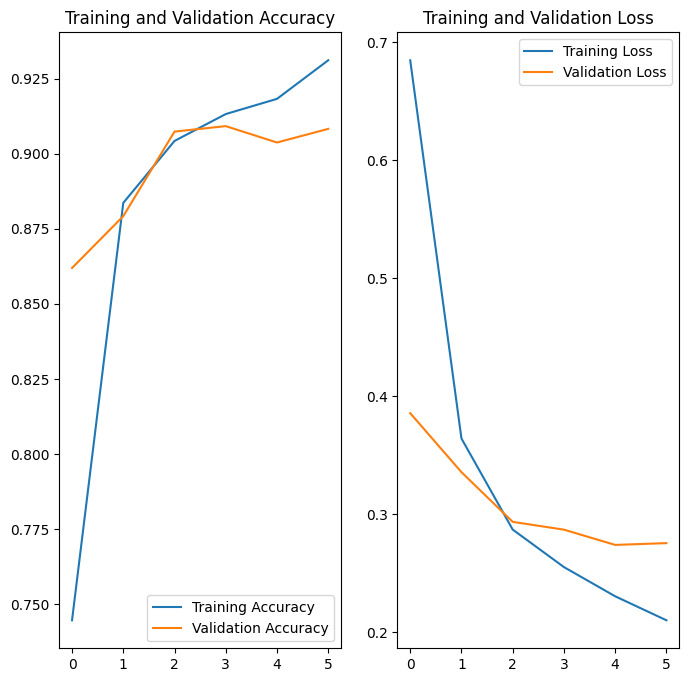

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()